# **TikTok Project**

## Using ML algorithms for predictive analysis

## Problem 

TikTok users have the ability to submit reports that identify videos and comments that contain user claims. These reports identify content that needs to be reviewed by moderators. The process generates a large number of user reports that are challenging to consider in a timely manner. 

We work on the development of a predictive model that can determine whether a video contains a claim or offers an opinion. With a successful prediction model, TikTok can reduce the backlog of user reports and prioritize them more efficiently.

## Project Goal

The goal of this model is to predict whether a TikTok video presents a "claim" or presents an "opinion" using ML algorithms 
so as to **mitigate misinformation in videos on the TikTok platform**.

### Evaluation Metric

There are two possibilities for bad predictions:

1. **False positives:** When the model predicts a video is a claim when in fact it is an opinion
2. **False negatives:** When the model predicts a video is an opinion when in fact it is a claim

In general videos that are flagged as "claims" tend to voilate Tiktok's T&C and depending on the number of users who report them the top 5% might be reviewed by humans. Videos which are flagged as "opinions" are less likely to be reviewed so it is better to review "claim videos" with higher priority.


In the given scenario, it's better for the model to **predict false positives** when it makes a mistake, and worse for it to predict false negatives as it is very important to identify videos that break the terms of service, even if that means some opinion videos are misclassified as claims. The worst case for an opinion misclassified as a claim is that the video goes to human review. The worst case for a claim that's misclassified as an opinion is that the video does not get reviewed and it violates the terms of service. 

A video that violates the terms of service would be considered posted from a **banned author**.

Because it's more important to minimize false negatives, the model evaluation metric will be recall.

### **Task 1. Imports and data loading**

Start by importing packages needed to build machine learning models to achieve the goal of this project.

In [1]:
# Import packages for data manipulation
import pandas as pd
import numpy as np

# Import packages for data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Import packages for data preprocessing
from sklearn.feature_extraction.text import CountVectorizer

# Import packages for data modeling
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, accuracy_score, precision_score, \
recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay

from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from xgboost import plot_importance

In [2]:
# Load dataset into dataframe
df = pd.read_csv("tiktok_dataset.csv")

### **Task 2: Examine data, summary info, and descriptive stats**

Inspect the first five rows of the dataframe.

In [3]:
# Display first few rows

df.head()

,#,claim_status,video_id,video_duration_sec,video_transcription_text,verified_status,author_ban_status,video_view_count,video_like_count,video_share_count,video_download_count,video_comment_count
0,1,claim,7017666017,59,someone shared with me that drone deliveries a...,not verified,under review,343296.0,19425.0,241.0,1.0,0.0
1,2,claim,4014381136,32,someone shared with me that there are more mic...,not verified,active,140877.0,77355.0,19034.0,1161.0,684.0
2,3,claim,9859838091,31,someone shared with me that american industria...,not verified,active,902185.0,97690.0,2858.0,833.0,329.0
3,4,claim,1866847991,25,someone shared with me that the metro of st. p...,not verified,active,437506.0,239954.0,34812.0,1234.0,584.0
4,5,claim,7105231098,19,someone shared with me that the number of busi...,not verified,active,56167.0,34987.0,4110.0,547.0,152.0


Get the number of rows and columns in the dataset.

In [4]:
# Get number of rows and columns

df = df.drop(["#", "video_id"], axis = 1)


Get the data types of the columns.

In [5]:
# Get data types of columns

df.dtypes


claim_status                 object
video_duration_sec            int64
video_transcription_text     object
verified_status              object
author_ban_status            object
video_view_count            float64
video_like_count            float64
video_share_count           float64
video_download_count        float64
video_comment_count         float64
dtype: object

Get basic information about the dataset.

In [6]:
# Get basic information

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19382 entries, 0 to 19381
Data columns (total 10 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   claim_status              19084 non-null  object 
 1   video_duration_sec        19382 non-null  int64  
 2   video_transcription_text  19084 non-null  object 
 3   verified_status           19382 non-null  object 
 4   author_ban_status         19382 non-null  object 
 5   video_view_count          19084 non-null  float64
 6   video_like_count          19084 non-null  float64
 7   video_share_count         19084 non-null  float64
 8   video_download_count      19084 non-null  float64
 9   video_comment_count       19084 non-null  float64
dtypes: float64(5), int64(1), object(4)
memory usage: 1.5+ MB


Generate basic descriptive statistics about the dataset.

In [7]:
# Generate basic descriptive stats

df.describe()


,video_duration_sec,video_view_count,video_like_count,video_share_count,video_download_count,video_comment_count
count,19382.000000,19084.000000,19084.000000,19084.000000,19084.000000,19084.000000
mean,32.421732,254708.558688,84304.636030,16735.248323,1049.429627,349.312146
std,16.229967,322893.280814,133420.546814,32036.174350,2004.299894,799.638865
min,5.000000,20.000000,0.000000,0.000000,0.000000,0.000000
25%,18.000000,4942.500000,810.750000,115.000000,7.000000,1.000000
50%,32.000000,9954.500000,3403.500000,717.000000,46.000000,9.000000
75%,47.000000,504327.000000,125020.000000,18222.000000,1156.250000,292.000000
max,60.000000,999817.000000,657830.000000,256130.000000,14994.000000,9599.000000


Check for and handle missing values.

In [8]:
# Check for missing values

df.isna().sum()


claim_status                298
video_duration_sec            0
video_transcription_text    298
verified_status               0
author_ban_status             0
video_view_count            298
video_like_count            298
video_share_count           298
video_download_count        298
video_comment_count         298
dtype: int64

In [9]:
# Drop rows with missing values

df = df.dropna()

df.shape


(19084, 10)

Check for and handle duplicates.

In [10]:
# Check for duplicates

df.duplicated().sum()


0

Check class balance.

In [11]:
# Check class balance

df['claim_status'].value_counts(normalize = True)*100


claim_status
claim      50.345839
opinion    49.654161
Name: proportion, dtype: float64

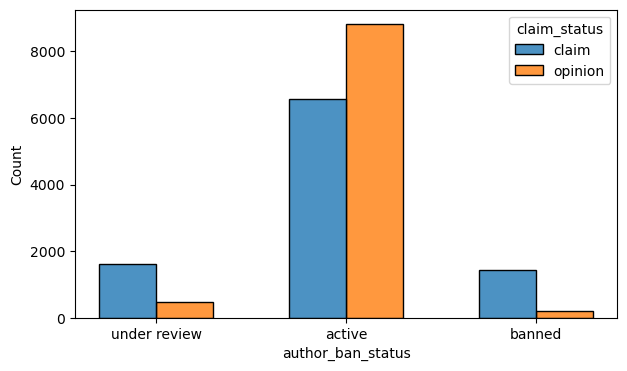

In [12]:
fig = plt.figure(figsize=(7,4))
sns.histplot(data=df, x='author_ban_status', hue='claim_status', multiple = 'dodge', alpha = 0.8, shrink = 0.6)
plt.show()

We see from the above statistic that 50% of the videos are claims and the other 50% are opinions but a vast majority of claims are either under review (78%) or get banned (88%) as compared to opinions (banned around 12% and under review around 78%) indicating that it is more important to flag claims

In [13]:
group_df = df.groupby(['claim_status', 'author_ban_status']).size().unstack()
group_df

col_sum = group_df.sum(axis = 0)

group_df_percent  = round(group_df/col_sum*100,3)

group_df_percent

author_ban_status,active,banned,under review
claim_status,,,
claim,42.683,88.012,77.59
opinion,57.317,11.988,22.41


### **Task 3: Feature engineering**

Extract the length of each `video_transcription_text` and add this as a column to the dataframe, so that it can be used as a potential feature in the model.

In [14]:
# Extract the length of each `video_transcription_text` and add this as a column to the dataframe

df['text_length'] = df['video_transcription_text'].apply(lambda x:len(x))

df.head()


,claim_status,video_duration_sec,video_transcription_text,verified_status,author_ban_status,video_view_count,video_like_count,video_share_count,video_download_count,video_comment_count,text_length
0,claim,59,someone shared with me that drone deliveries a...,not verified,under review,343296.0,19425.0,241.0,1.0,0.0,97
1,claim,32,someone shared with me that there are more mic...,not verified,active,140877.0,77355.0,19034.0,1161.0,684.0,107
2,claim,31,someone shared with me that american industria...,not verified,active,902185.0,97690.0,2858.0,833.0,329.0,137
3,claim,25,someone shared with me that the metro of st. p...,not verified,active,437506.0,239954.0,34812.0,1234.0,584.0,131
4,claim,19,someone shared with me that the number of busi...,not verified,active,56167.0,34987.0,4110.0,547.0,152.0,128


Calculate the average text_length for claims and opinions.

In [15]:
# Calculate the average text_length for claims and opinions

df.groupby('claim_status')['text_length'].mean()

claim_status
claim      95.376978
opinion    82.722562
Name: text_length, dtype: float64

Visualize the distribution of `text_length` for claims and opinions.

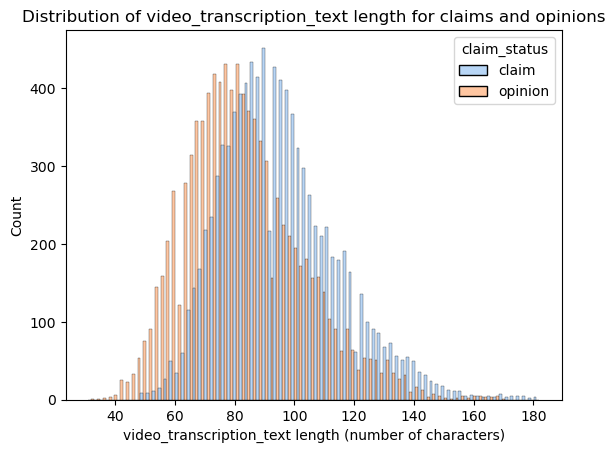

In [16]:
# Visualize the distribution of `text_length` for claims and opinions
# Create two histograms in one plot
sns.histplot(data=df, stat="count", multiple="dodge", x="text_length",
             kde=False, palette="pastel", hue="claim_status",
             element="bars", legend=True)
plt.xlabel("video_transcription_text length (number of characters)")
plt.ylabel("Count")
plt.title("Distribution of video_transcription_text length for claims and opinions")
plt.show()

People reporting claims on average use more words in their report (by 13 words) maybe indicating the place or the time stamp where the T&C were voilated 

**Feature selection and transformation**

Encode target and catgorical variables.

In [17]:
df['claim_status'] = df['claim_status'].replace({'opinion':0, 'claim':1})

df.head()


,claim_status,video_duration_sec,video_transcription_text,verified_status,author_ban_status,video_view_count,video_like_count,video_share_count,video_download_count,video_comment_count,text_length
0,1,59,someone shared with me that drone deliveries a...,not verified,under review,343296.0,19425.0,241.0,1.0,0.0,97
1,1,32,someone shared with me that there are more mic...,not verified,active,140877.0,77355.0,19034.0,1161.0,684.0,107
2,1,31,someone shared with me that american industria...,not verified,active,902185.0,97690.0,2858.0,833.0,329.0,137
3,1,25,someone shared with me that the metro of st. p...,not verified,active,437506.0,239954.0,34812.0,1234.0,584.0,131
4,1,19,someone shared with me that the number of busi...,not verified,active,56167.0,34987.0,4110.0,547.0,152.0,128


In [18]:
df = pd.get_dummies(df, columns = ['verified_status', 'author_ban_status'], drop_first = True)
df = df.drop(['video_transcription_text'], axis = 1).astype(int)

df.head()

,claim_status,video_duration_sec,video_view_count,video_like_count,video_share_count,video_download_count,video_comment_count,text_length,verified_status_verified,author_ban_status_banned,author_ban_status_under review
0,1,59,343296,19425,241,1,0,97,0,0,1
1,1,32,140877,77355,19034,1161,684,107,0,0,0
2,1,31,902185,97690,2858,833,329,137,0,0,0
3,1,25,437506,239954,34812,1234,584,131,0,0,0
4,1,19,56167,34987,4110,547,152,128,0,0,0


### **Task 4: Split the data**

In [41]:
# Isolate target variable
X = df.drop('claim_status', axis = 1)
y = df['claim_status']    
    


#### **Task 5: Create train/validate/test sets**

Split data into training and testing sets, 80/20.

In [42]:
# Split the data into training and testing sets

X_tr, X_test, y_tr, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

Split the training set into training and validation sets, 75/25, to result in a final ratio of 60/20/20 for train/validate/test sets.

In [43]:
# Split the training data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_tr, y_tr, test_size=0.25, random_state=0)


### **Task 6. Build models**


### **Build a random forest model**

Fit a random forest model to the training set. Use cross-validation to tune the hyperparameters and select the model that performs best on recall.

In [45]:
# Instantiate the random forest classifier
rf = RandomForestClassifier(random_state=0)

# Create a dictionary of hyperparameters to tune
cv_params = {'max_depth': [5, 7, None],
             'max_features': [0.3, 0.6],
            #  'max_features': 'auto'
             'max_samples': [0.7],
             'min_samples_leaf': [1,2],
             'min_samples_split': [2,3],
             'n_estimators': [75,100,200],
             }

# Define a dictionary of scoring metrics to capture
scoring = {'accuracy', 'precision', 'recall', 'f1'}

# Instantiate the GridSearchCV object
rf_cv = GridSearchCV(rf, cv_params, scoring=scoring, cv=5, refit='recall')

In [47]:
rf_cv.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=0),
             param_grid={'max_depth': [5, 7, None], 'max_features': [0.3, 0.6],
                         'max_samples': [0.7], 'min_samples_leaf': [1, 2],
                         'min_samples_split': [2, 3],
                         'n_estimators': [75, 100, 200]},
             refit='recall', scoring={'f1', 'recall', 'accuracy', 'precision'})

In [48]:
# Examine best recall score

rf_cv.best_score_

0.9908534395531852

In [50]:
# Examine best parameters
rf_cv.best_params_


{'max_depth': 5,
 'max_features': 0.6,
 'max_samples': 0.7,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 75}

### **Build an XGBoost model**

In [52]:
# Instantiate the XGBoost classifier
# Instantiate the XGBoost classifier
xgb = XGBClassifier(objective='binary:logistic', random_state=0)

# Create a dictionary of hyperparameters to tune
cv_params = {'max_depth': [4,8,12],
             'min_child_weight': [3, 5],
             'learning_rate': [0.01, 0.1],
             'n_estimators': [300, 500]
             }

# Define a dictionary of scoring metrics to capture
scoring = {'accuracy', 'precision', 'recall', 'f1'}

# Instantiate the GridSearchCV object
xgb_cv = GridSearchCV(xgb, cv_params, scoring=scoring, cv=5, refit='recall')

In [54]:
xgb_cv.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=0, ...),
             param_grid={'learning_rate': [0.01, 0.1], 'max_depth': [4, 8, 12],
                         'min_child_weight': [3, 5],
                         'n_estimators': [300, 500]},
             refit='recall', scoring={'f1', 'recall', 'accuracy', 'precision'})

In [57]:
xgb_cv.best_score_

0.9906808769992594

In [58]:
xgb_cv.best_params_

{'learning_rate': 0.1,
 'max_depth': 4,
 'min_child_weight': 5,
 'n_estimators': 300}

### **Task 7. Evaluate model**

Evaluate models against validation criteria.

#### **Random forest**

In [59]:
# Use the random forest "best estimator" model to get predictions on the encoded testing set
y_pred = rf_cv.best_estimator_.predict(X_val)

Create a confusion matrix to visualize the results of the classification model.

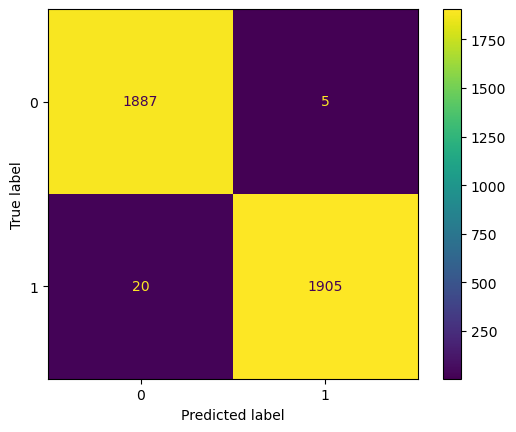

In [60]:

# Create a confusion matrix to visualize the results of the classification model

# Compute values for confusion matrix
log_cm = confusion_matrix(y_val, y_pred)

# Create display of confusion matrix
log_disp = ConfusionMatrixDisplay(confusion_matrix=log_cm, display_labels=None)

# Plot confusion matrix
log_disp.plot()

# Display plot
plt.show()

Create a classification report that includes precision, recall, f1-score, and accuracy metrics to evaluate the performance of the model.

In [62]:
# Create a classification report
target_labels = ['opinion', 'claim']
print(classification_report(y_val, y_pred, target_names=target_labels))

              precision    recall  f1-score   support

     opinion       0.99      1.00      0.99      1892
       claim       1.00      0.99      0.99      1925

    accuracy                           0.99      3817
   macro avg       0.99      0.99      0.99      3817
weighted avg       0.99      0.99      0.99      3817



In [65]:
# Metrics 
preds = y_pred
accuracy = accuracy_score(y_val, preds)
precision = precision_score(y_val, preds)
recall = recall_score(y_val, preds)
f1 = f1_score(y_val, preds)
print(f'TP = 1887, TN = 1905, FN = 20, FP = 5')
print(f'accuracy = {accuracy}')
print(f'precision = {precision}')
print(f'recall = {recall}')
print(f'f1 = {f1}')


TP = 1887, TN = 1905, FN = 20, FP = 5
accuracy = 0.9934503536809012
precision = 0.9973821989528796
recall = 0.9896103896103896
f1 = 0.9934810951760106


In [68]:
rf_importances = pd.DataFrame(data=rf_cv.best_estimator_.feature_importances_, index=X.columns, columns=['gini criterion'])

rf_importances = rf_importances.sort_values(by = 'gini criterion', ascending= False)

rf_importances

,gini criterion
video_view_count,0.653320
video_like_count,0.232455
video_share_count,0.056994
video_download_count,0.045059
video_comment_count,0.011255
text_length,0.000443
video_duration_sec,0.000241
author_ban_status_banned,0.000204
author_ban_status_under review,0.000029
verified_status_verified,0.000000


<Axes: xlabel='gini criterion'>

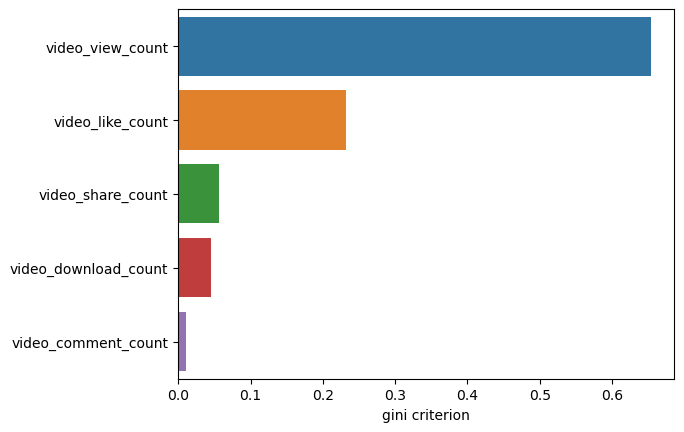

In [69]:
sns.barplot(data = rf_importances[:5], x = 'gini criterion', y = rf_importances.index[:5])

In [70]:
results_rf = [accuracy, precision, recall, f1, 'view_count', 'like_count','share_count', 'download_count' ]
results_rf

[0.9934503536809012,
 0.9973821989528796,
 0.9896103896103896,
 0.9934810951760106,
 'view_count',
 'like_count',
 'share_count',
 'download_count']

### Summary for Random Forests

1. We get a nearly perfect classification with a recall of 0.99 and only 5 false negatives which means our model did a great job
2. View count and like count dominate as the most important features in determining if a video is a claim or an opinion

#### **XGBoost**

In [71]:
#Evaluate XGBoost model
y_pred = xgb_cv.best_estimator_.predict(X_val)

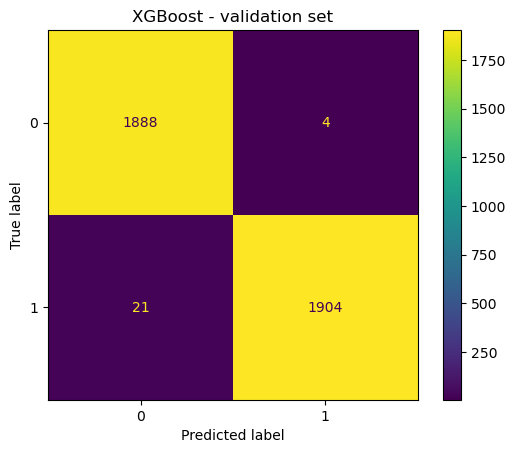

In [72]:
# Compute values for confusion matrix
# Compute values for confusion matrix
log_cm = confusion_matrix(y_val, y_pred)

# Create display of confusion matrix
log_disp = ConfusionMatrixDisplay(confusion_matrix=log_cm, display_labels=None)

# Plot confusion matrix
log_disp.plot()

# Display plot
plt.title('XGBoost - validation set');
plt.show()


In [74]:
# Create a classification report

target_labels = ['opinion', 'claim']
print(classification_report(y_val, y_pred, target_names=target_labels))

              precision    recall  f1-score   support

     opinion       0.99      1.00      0.99      1892
       claim       1.00      0.99      0.99      1925

    accuracy                           0.99      3817
   macro avg       0.99      0.99      0.99      3817
weighted avg       0.99      0.99      0.99      3817



In [81]:
importances = xgb_cv.best_estimator_.feature_importances_
xgb_cv_importances = pd.DataFrame(importances, index=X_test.columns, columns = ['gini criterion'])

xgb_cv_importances = xgb_cv_importances.sort_values(by='gini criterion', ascending=False)

xgb_cv_importances

,gini criterion
video_view_count,0.911894
video_like_count,0.025853
verified_status_verified,0.015196
author_ban_status_banned,0.010449
video_comment_count,0.010274
video_download_count,0.008580
text_length,0.006808
video_duration_sec,0.005800
video_share_count,0.005147
author_ban_status_under review,0.000000


<Axes: xlabel='gini criterion'>

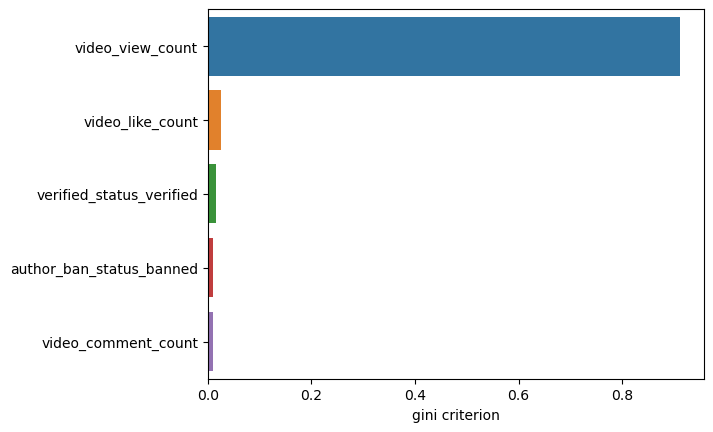

In [84]:
sns.barplot(data = xgb_cv_importances.head(), x = 'gini criterion', y = xgb_cv_importances.head().index)

In [85]:
results_xgb = [accuracy, precision, recall, f1, 'view_count', 'like_count','verification_status', 'author_banned_status']

results_xgb


[0.9934503536809012,
 0.9973821989528796,
 0.9896103896103896,
 0.9934810951760106,
 'view_count',
 'like_count',
 'verification_status',
 'author_banned_status']

### Summary for XGBoost

1. We get a nearly perfect classification with a recall of 0.99 and only 4 false negatives which means our model did a great job
2. View count and like count dominate as the most important features in determining if a video is a claim or an opinion
3. Compared to the rf method the view_count seems to have an overwelheing importance in deciding the claim status

In [89]:
results_rf

['Random Forests',
 0.9934503536809012,
 0.9973821989528796,
 0.9896103896103896,
 0.9934810951760106,
 'view_count',
 'like_count',
 'share_count',
 'download_count']

In [98]:
# Define the column names for the DataFrame
columns = ['Method', 'Accuracy', 'Precision', 'Recall', 'f1', 'feature_1', 'feature_2', 'feature_3', 'feature_4']

# Create DataFrames from the lists
df_rf = pd.DataFrame([results_rf], columns=columns)
df_xgb = pd.DataFrame([results_xgb], columns=columns)

# Concatenate DataFrames along the row axis and reset index
results_df = pd.concat([df_rf, df_xgb], axis=0, ignore_index=True)

# Display the concatenated DataFrame
print(results_df)

           Method  Accuracy  Precision   Recall        f1   feature_1  \
0  Random Forests   0.99345   0.997382  0.98961  0.993481  view_count   
1        XG Boost   0.99345   0.997382  0.98961  0.993481  view_count   

    feature_2            feature_3             feature_4  
0  like_count          share_count        download_count  
1  like_count  verification_status  author_banned_status  


Since the 2 methods give almost similar results it does not matter which method we choose so using the flip of a coin we choose the XG Boost method

### **Use champion model to predict on test data**

In [99]:
y_pred = xgb_cv.best_estimator_.predict(X_test)


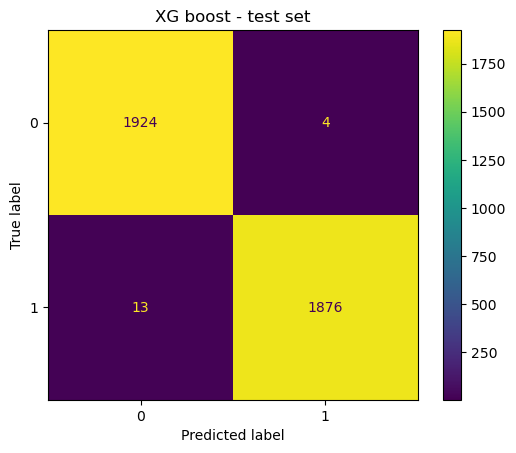

In [100]:
# Compute values for confusion matrix
log_cm = confusion_matrix(y_test, y_pred)

# Create display of confusion matrix
log_disp = ConfusionMatrixDisplay(confusion_matrix=log_cm, display_labels=None)

# Plot confusion matrix
log_disp.plot()

# Display plot
plt.title('XG boost - test set');
plt.show()

In [102]:
target_labels = ['opinion', 'claim']
print(classification_report(y_test, y_pred, target_names=target_labels))


              precision    recall  f1-score   support

     opinion       0.99      1.00      1.00      1928
       claim       1.00      0.99      1.00      1889

    accuracy                           1.00      3817
   macro avg       1.00      1.00      1.00      3817
weighted avg       1.00      1.00      1.00      3817



### **Task 8. Conclusion**

1. One can recommend this model because it performed well on both the validation and test holdout data. Furthermore, both precision and F<sub>1</sub> scores were consistently high. The model very successfully classified claims and opinions.
</br>
2. The model's most predictive features were all related to the user engagement levels associated with each video. It was classifying videos based on how many views, likes, shares, and downloads they received.
</br>
3. Because the model currently performs nearly perfectly, there is no need to engineer any new features.
</br>
4. The current version of the model does not need any new features. However, it would be helpful to have the number of times the video was reported. It would also be useful to have the total number of user reports for all videos posted by each author.